In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords, brown
from nltk import word_tokenize
from nltk.util import ngrams
import math
stop_words = set(stopwords.words('english'))
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
%matplotlib inline

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [41]:
#importing the data
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


#### Baseline Model

In [42]:
#nlp/machine learning libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import f1_score,classification_report,roc_curve,precision_recall_curve,auc,average_precision_score
from sklearn.feature_selection import chi2, SelectKBest
import re
import pandas, xgboost, numpy, textblob, string
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [43]:
#display top 5 rows
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [44]:
test_df.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


### Using only text column (question_text) for building models

In [45]:
#features
X = train_df['question_text']
#target label
Y = train_df['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

## Baseline model - Logistic Regression

In [46]:
#pipeline for creating tf idf and  basic logistic regression model
baseline_lr = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('classifier', LogisticRegression()),
                    ])

In [47]:
#fitting the pipeline to the train data
baseline_lr.fit(X_train, y_train )

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [48]:
baseline_lr_preds = baseline_lr.predict(X_test)
print(classification_report(y_test, baseline_lr_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    245131
           1       0.69      0.37      0.48     16094

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.82      0.68      0.73    261225
weighted avg       0.94      0.95      0.94    261225



In [49]:
baseline_lr_preds_prob = baseline_lr.predict_proba(X_test)[:,1]

#### Choosing Optimal threshold with better F1 score

In [50]:
f1_list = []
for threshold in np.arange(0.1, 0.6, 0.01):
    threshold = np.round(threshold, 2)
    f1_list.append((f1_score(y_test, (baseline_lr_preds_prob>threshold).astype(int)),threshold))
    print("F1 score at threshold {0} is {1}".format(threshold, f1_score(y_test, (baseline_lr_preds_prob>threshold).astype(int))))

F1 score at threshold 0.1 is 0.536083299959952
F1 score at threshold 0.11 is 0.5480727090594152
F1 score at threshold 0.12 is 0.5583883894725441
F1 score at threshold 0.13 is 0.5678053597881223
F1 score at threshold 0.14 is 0.5742010189902733
F1 score at threshold 0.15 is 0.5791408114558473
F1 score at threshold 0.16 is 0.5840734016976596
F1 score at threshold 0.17 is 0.5871462709093196
F1 score at threshold 0.18 is 0.5910355486862443
F1 score at threshold 0.19 is 0.5923586990843068
F1 score at threshold 0.2 is 0.5948475232614425
F1 score at threshold 0.21 is 0.594995060915377
F1 score at threshold 0.22 is 0.5944646351691362
F1 score at threshold 0.23 is 0.5942710560068405
F1 score at threshold 0.24 is 0.5939313065676491
F1 score at threshold 0.25 is 0.5917337817505975
F1 score at threshold 0.26 is 0.5891956782713085
F1 score at threshold 0.27 is 0.587805101014718
F1 score at threshold 0.28 is 0.5852948463825571
F1 score at threshold 0.29 is 0.583881010031131
F1 score at threshold 0.3 

In [51]:
def sort_tuple(tup):
    return tup[0]

best_threshold = sorted(f1_list,key=sort_tuple, reverse=True)[0][1]

In [52]:
##creating a submission file with the optimal threshold with the baseline model
def submission(df, predictions, file_name, threshold=0.20):
    print('Optimal threshold with better F1 score is: ', threshold)
    results = (predictions > threshold).astype(int)
    df['prediction'] = results
    file = (file_name + '.csv')
    df.to_csv(file, index=False)

In [53]:
#predicting the classes on test data
baseline_lr_preds_prob = baseline_lr.predict_proba(test_df['question_text'])

In [54]:
baseline_lr_preds_prob

array([[0.99171998, 0.00828002],
       [0.994045  , 0.005955  ],
       [0.98579683, 0.01420317],
       ...,
       [0.99180229, 0.00819771],
       [0.98323511, 0.01676489],
       [0.20384503, 0.79615497]])

In [55]:
print('Saving the results in the submission file')
sub_df = pd.read_csv('../input/sample_submission.csv')
submission(sub_df, baseline_lr_preds_prob, 'submission', threshold=best_threshold)

Saving the results in the submission file
Optimal threshold with better F1 score is:  0.21


In [56]:
print("At threshold {0}, we are getting better F1 score and we will be choosing this threshold for our submission. This is our baseline and we will try to beat this score".format(best_threshold))

At threshold 0.21, we are getting better F1 score and we will be choosing this threshold for our submission. This is our baseline and we will try to beat this score


## Naive Bayes

In [57]:
#pipeline for creating tf idf and  naive bayes model
naive_bayes = Pipeline([
                    ('count_vect', CountVectorizer()),
                    ('classifier', MultinomialNB()),
                    ])

In [58]:
#fitting the pipeline to the train data
naive_bayes.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [59]:
naive_bayes_preds = naive_bayes.predict(X_test)
print(classification_report(y_test, naive_bayes_preds))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    245131
           1       0.47      0.69      0.56     16094

   micro avg       0.93      0.93      0.93    261225
   macro avg       0.73      0.82      0.76    261225
weighted avg       0.95      0.93      0.94    261225



In [60]:
naive_bayes_preds_prob = naive_bayes.predict_proba(X_test)[:,1]


#### Choosing Optimal threshold with better F1 score

In [61]:
f1_list = []
for threshold in np.arange(0.1, 0.8, 0.01):
    threshold = np.round(threshold, 2)
    f1_list.append((f1_score(y_test, (naive_bayes_preds_prob>threshold).astype(int)),threshold))
    print("F1 score at threshold {0} is {1}".format(threshold, f1_score(y_test, (naive_bayes_preds_prob>threshold).astype(int))))

F1 score at threshold 0.1 is 0.47847826086956524
F1 score at threshold 0.11 is 0.4841464539334133
F1 score at threshold 0.12 is 0.4886465827338129
F1 score at threshold 0.13 is 0.4937477398602995
F1 score at threshold 0.14 is 0.4975381823096677
F1 score at threshold 0.15 is 0.5011350293542075
F1 score at threshold 0.16 is 0.5054004241067005
F1 score at threshold 0.17 is 0.5091703581951933
F1 score at threshold 0.18 is 0.5126468022960995
F1 score at threshold 0.19 is 0.5153552831194391
F1 score at threshold 0.2 is 0.51814887669531
F1 score at threshold 0.21 is 0.521075520615539
F1 score at threshold 0.22 is 0.5239472295514511
F1 score at threshold 0.23 is 0.5264167021729868
F1 score at threshold 0.24 is 0.5291867262723521
F1 score at threshold 0.25 is 0.5312709863304521
F1 score at threshold 0.26 is 0.5331616507714803
F1 score at threshold 0.27 is 0.53512205850011
F1 score at threshold 0.28 is 0.5368544652945477
F1 score at threshold 0.29 is 0.5388339766616836
F1 score at threshold 0.3 

In [62]:
def sort_tuple(tup):
    return tup[0]

best_threshold = sorted(f1_list,key=sort_tuple, reverse=True)[0][1]

In [64]:
#predicting the classes on test data
naive_bayes_preds_prob = naive_bayes.predict_proba(test_df['question_text'])

In [66]:
print('Saving the results in the submission file')
sub_df = pd.read_csv('../input/sample_submission.csv')
submission(sub_df, naive_bayes_preds_prob, 'submission', threshold=best_threshold)

Saving the results in the submission file
Optimal threshold with better F1 score is:  0.73


In [67]:
print("At threshold {0} we are getting better F1 score and we will be choosing this threshold for our submission.".format(best_threshold))

At threshold 0.73 we are getting better F1 score and we will be choosing this threshold for our submission.


## Random Forest

In [69]:
#pipeline for creating tf idf and  naive bayes model
random_forest = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('classifier', RandomForestClassifier()),
                    ])

In [70]:
#fitting the pipeline to the train data
random_forest.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [71]:
random_forest_preds = random_forest.predict(X_test)
print(classification_report(y_test, random_forest_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    245131
           1       0.67      0.19      0.29     16094

   micro avg       0.94      0.94      0.94    261225
   macro avg       0.81      0.59      0.63    261225
weighted avg       0.93      0.94      0.93    261225



In [72]:
random_forest_preds_prob = random_forest.predict_proba(X_test)[:,1]

#### Choosing Optimal threshold with better F1 score


In [73]:
f1_list = []
for threshold in np.arange(0.1, 0.8, 0.01):
    threshold = np.round(threshold, 2)
    f1_list.append((f1_score(y_test, (random_forest_preds_prob>threshold).astype(int)),threshold))
    print("F1 score at threshold {0} is {1}".format(threshold, f1_score(y_test, (random_forest_preds_prob>threshold).astype(int))))

F1 score at threshold 0.1 is 0.5066816104836623
F1 score at threshold 0.11 is 0.5072983244083608
F1 score at threshold 0.12 is 0.5078712914107776
F1 score at threshold 0.13 is 0.5083116883116883
F1 score at threshold 0.14 is 0.5086214366172777
F1 score at threshold 0.15 is 0.5088331563089329
F1 score at threshold 0.16 is 0.5088441862481574
F1 score at threshold 0.17 is 0.50882518756234
F1 score at threshold 0.18 is 0.5088362209163649
F1 score at threshold 0.19 is 0.5088362209163649
F1 score at threshold 0.2 is 0.5322585207184273
F1 score at threshold 0.21 is 0.5325819149839993
F1 score at threshold 0.22 is 0.532759011562004
F1 score at threshold 0.23 is 0.5330913627856859
F1 score at threshold 0.24 is 0.5333333333333334
F1 score at threshold 0.25 is 0.5333333333333333
F1 score at threshold 0.26 is 0.5333484766745222
F1 score at threshold 0.27 is 0.5334734569829863
F1 score at threshold 0.28 is 0.5335340738005283
F1 score at threshold 0.29 is 0.5335340738005283
F1 score at threshold 0.3

In [74]:
def sort_tuple(tup):
    return tup[0]

best_threshold = sorted(f1_list,key=sort_tuple, reverse=True)[0][1]

In [75]:
#predicting the classes on test data
random_forest_preds_prob = random_forest.predict_proba(test_df['question_text'])

In [76]:
print('Saving the results in the submission file')
sub_df = pd.read_csv('../input/sample_submission.csv')
submission(sub_df, random_forest_preds_prob, 'submission', threshold=best_threshold)

Saving the results in the submission file
Optimal threshold with better F1 score is:  0.28


In [77]:
print("At threshold {0} we are getting better F1 score and we will be choosing this threshold for our submission.".format(best_threshold))

At threshold 0.28 we are getting better F1 score and we will be choosing this threshold for our submission.


### Precision Recall Curves

In [80]:
baseline_lr_preds_prob = baseline_lr.predict_proba(X_test)[:,1]
naive_bayes_preds_prob = naive_bayes.predict_proba(X_test)[:,1]
random_forest_preds_prob = random_forest.predict_proba(X_test)[:,1]


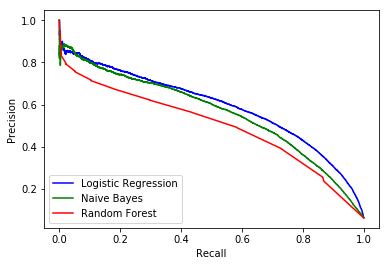

In [84]:
classfier_pred_list = [baseline_lr_preds_prob,naive_bayes_preds_prob,random_forest_preds_prob]
classifiers_list = ['Logistic Regression','Naive Bayes','Random Forest']
count=0
for classifier,col in zip(classfier_pred_list,'bgr'):
    p,r,_ = precision_recall_curve(y_test,classifier)   
    plt.plot(r,p,c=col,label=classifiers_list[count])
    count += 1
plt.legend(loc='lower left')   
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()